   Month  Cumulative_Customers  New_Customers  Year
0      0                   149            149     1
1      1                   182             33     1
2      2                   222             40     1
3      3                   271             49     1
4      4                   331             60     1
New customers in month 12: 293


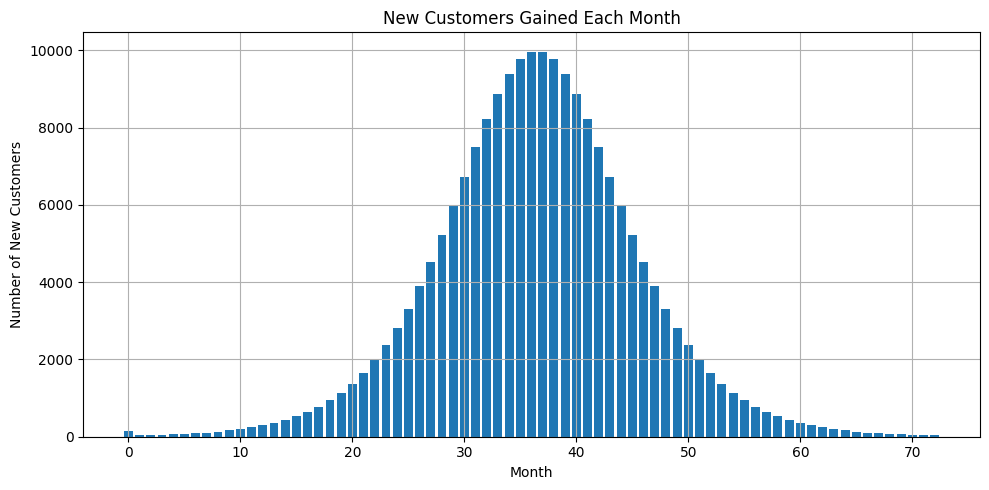

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
K = 200000        # Market capacity (max users)
r = 0.20          # Growth rate
t0 = 36           # Inflection point (month)
t = np.arange(0, 73, 1)  # Months 0–72 (6 years)

# Logistic Growth Function
def logistic_growth(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

# Customer Growth
customers = logistic_growth(t, K, r, t0)
new_customers = np.diff(customers, prepend=0)

# DataFrame
df = pd.DataFrame({
    "Month": t,
    "Cumulative_Customers": customers.astype(int),
    "New_Customers": new_customers.astype(int)
})

df["Year"] = df["Month"] // 12 + 1

print(df.head())
print(f"New customers in month 12: {df.loc[df['Month'] == 12, 'New_Customers'].values[0]}")

# Plot New Customers Per Month
plt.figure(figsize=(10, 5))
plt.bar(df["Month"], df["New_Customers"])
plt.title("New Customers Gained Each Month")
plt.xlabel("Month")
plt.ylabel("Number of New Customers")
plt.grid(True)
plt.tight_layout()
plt.show()


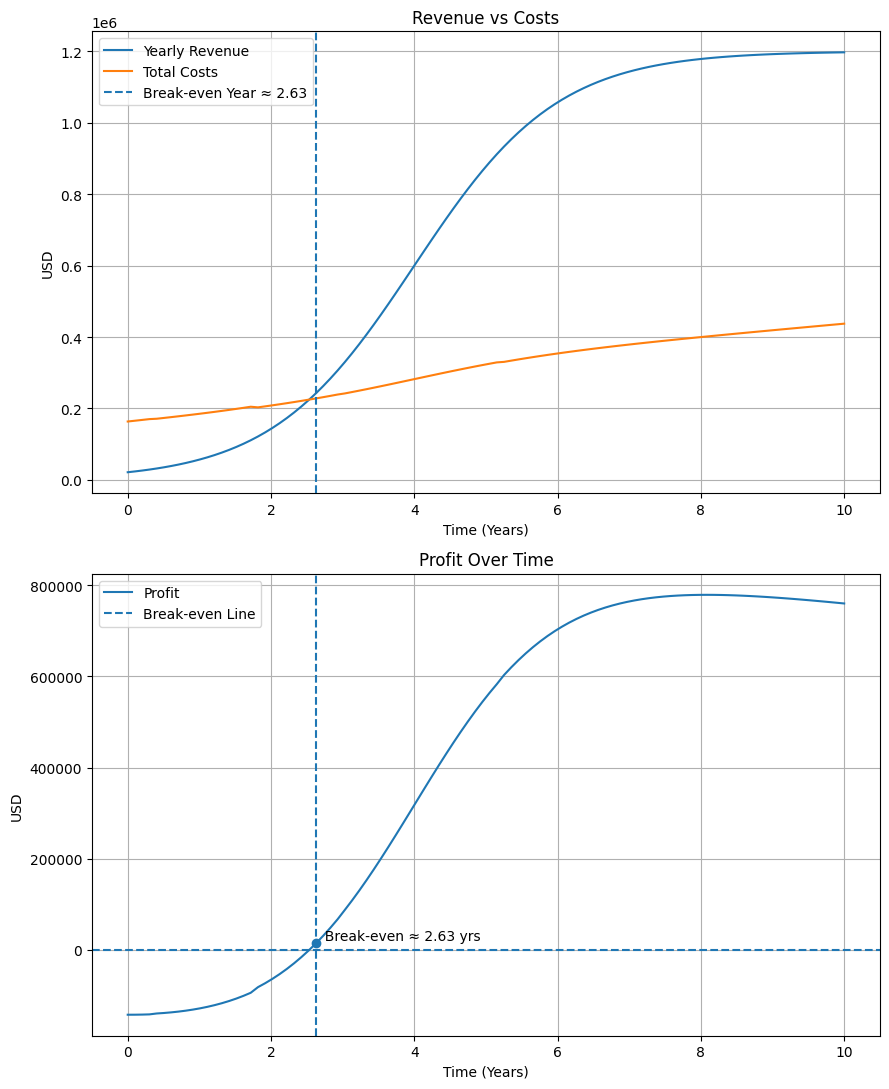

Break-even reached at approximately year 2.63


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Customer Growth (Yearly)
L = 200000   # Max users
t0 = 4       # Inflection year
k = 1        # Growth steepness
t = np.linspace(0, 10, 100) 

def sigmoid(t, L, t0, k):
    return L / (1 + np.exp(-k * (t - t0)))

users_over_time = sigmoid(t, L, t0, k)

# Revenue Model
revenue_per_user = 10 * 12   # $10/month
premium_conversion_rate = 0.05

yearly_revenue = (
    users_over_time *
    revenue_per_user *
    premium_conversion_rate
)

# Infrastructure Cost Model
def infrastructure_cost(users, storage_per_user_gb=1):
    users = int(users)

    # Compute cost per user (economies of scale)
    if users < 1000:
        compute_cost_per_user = 0.08
    elif users < 5000:
        compute_cost_per_user = 0.06
    elif users < 20000:
        compute_cost_per_user = 0.04
    else:
        compute_cost_per_user = 0.02

    compute_cost = users * compute_cost_per_user

    # Storage cost
    storage_cost_per_gb = 0.023
    total_storage_gb = users * storage_per_user_gb

    if total_storage_gb < 50 * 1024:         # < 50 TB
        storage_cost = storage_cost_per_gb * total_storage_gb
    elif total_storage_gb < 150 * 1024:      # 50–150 TB
        storage_cost = storage_cost_per_gb * total_storage_gb * 0.95
    elif total_storage_gb < 500 * 1024:      # 150–500 TB
        storage_cost = storage_cost_per_gb * total_storage_gb * 0.90
    else:
        storage_cost = storage_cost_per_gb * total_storage_gb * 0.85

    return compute_cost + storage_cost

# Costs
yearly_variable_cost = np.array([
    infrastructure_cost(u) * 12 for u in users_over_time
])

mvp_cost = 50000
initial_dev_cost = 80000
development_costs = np.linspace(
    initial_dev_cost,
    initial_dev_cost * 2,
    len(t)
)

operational_costs = 30000 + 10000 * t

total_costs = (
    yearly_variable_cost +
    development_costs +
    operational_costs +
    mvp_cost
)

# Profit
profit = yearly_revenue - total_costs

# Break-even Detection
break_even_index = np.where(profit >= 0)[0]

if len(break_even_index) > 0:
    be_i = break_even_index[0]
    break_even_year = t[be_i]
    break_even_profit = profit[be_i]
else:
    break_even_year = None

# Plot Revenue vs Cost
fig, ax = plt.subplots(2, 1, figsize=(9, 11))

ax[0].plot(t, yearly_revenue, label="Yearly Revenue")
ax[0].plot(t, total_costs, label="Total Costs")

if break_even_year is not None:
    ax[0].axvline(x=break_even_year, linestyle="--", label=f"Break-even Year ≈ {break_even_year:.2f}")

ax[0].set_xlabel("Time (Years)")
ax[0].set_ylabel("USD")
ax[0].set_title("Revenue vs Costs")
ax[0].legend()
ax[0].grid(True)

# Plot Profit
ax[1].plot(t, profit, label="Profit")
ax[1].axhline(y=0, linestyle="--", label="Break-even Line")

if break_even_year is not None:
    ax[1].scatter(break_even_year, break_even_profit)
    ax[1].axvline(x=break_even_year, linestyle="--")
    ax[1].text(
        break_even_year,
        break_even_profit,
        f"  Break-even ≈ {break_even_year:.2f} yrs",
        verticalalignment='bottom'
    )

ax[1].set_xlabel("Time (Years)")
ax[1].set_ylabel("USD")
ax[1].set_title("Profit Over Time")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# Console Output
if break_even_year is not None:
    print(f"Break-even reached at approximately year {break_even_year:.2f}")
else:
    print("Break-even not reached within simulation period")
